In [264]:
#region Chargement des packages
#from IPython import get_ipython;
#get_ipython().magic('reset -sf')
import os
import sys
if os.path.basename(os.getcwd())=='Prospective_conso':
    sys.path.append('../../')
from functions.f_notebook import hide_toggle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from functions.f_tools import *
from functions.f_graphicalTools import *
from Models.Prospective_conso.f_evolution_tools import *
from mycolorpy import colorlist as mcp
import qgrid # great package https://github.com/quantopian/qgrid
import numpy as np
import time
from plotnine import *
from functools import reduce
dpe_colors = ['#009900', '#33cc33', '#B3FF00', '#e6e600', '#FFB300', '#FF4D00', '#FF0000',"#000000"]

# print(os.getcwd())
Graphic_folder = "Graphics/"
Data_folder = "data/"
# endregion

# Tertiary building stock evolution

## *Defining an initial configuration and energy retrofit pathways*

### Table of Contents

* [1. Introduction](#intro)
* [2. Initial state of the building stock](#initialstate)
* [3. Decarbonization of building stock heating](#decarbonization)
    * [3.1 An example path towards emission reduction ](#firstpath)
    * [3.2 Achieving SNBC objectives through electrification](#electrification)
    * [3.3 Technical constraints and alternative paths](#alternatives)
* [4. Input data structure](#inputdata)


## 1. Introduction <a class="anchor" id="intro"></a>

This notebook will guide you through the undersanding of the heating demand in french residential and tertiary sectors. First of all, a basic representation of the building stock is used to characterise the initial state of the buildings and heating systems. Then, different modification can be applied to this initial situation in order to draw paths towards 2050, with the aim of reducing carbon emissions.not

This guided work shall permit you to draw yourself some paths towards a cleaner future for building heating sector, considering technical and temporal constraints.

The scope of this work is Metropolitan France and all the data used in this work are extracted from french governemental institutions, such as ADEME, SDES, INSEE...

## 2. Initial state of the building stock <a class="anchor" id="initialstate"></a>

First and foremost, we load the input data, stored in an excel file. More detail on the input structure and content can be found in [Section 4](#inputdata). These input data are extracted from the different sheets and stored in sim_param dictionnary.

In [318]:
#Four dimensions in the dataset
dim_names = ["Energy_source", "building_type", "Vecteur", "year"];
#Two main indexes
Index_names = ["Energy_source", "building_type"];
Energy_system_name = "Energy_source"
#Reading the data
data_set_from_excel = pd.read_excel(Data_folder + "Hypotheses_residential_tertiary_BASIC.xlsx", None);
#Extracting info from sheets and creating indexes etc
sim_param = extract_sim_param(data_set_from_excel, Index_names=Index_names, dim_names=dim_names,
                              Energy_system_name=Energy_system_name)
#Creating the initial building description
sim_param["init_sim_stock"] = create_initial_parc(sim_param).sort_index()
sim_param["volume_variable_name"] = "surface"
sim_param["init_sim_stock"]["surface"] = sim_param["init_sim_stock"]["surface"] * sim_param["init_sim_stock"]["IPONDL"]

# We adjust energy need for electricity considering the primary energy factor
sim_param["init_sim_stock"]["conso_unitaire_elec"]=sim_param["init_sim_stock"]["conso_unitaire_elec"]/2.3
sim_param_copy4plot=sim_param.copy()


The initial state of French building stock can be summarized and vizualized ploting a few graphs. Fot this, we gather all the info in a single dataframe (emission factors, efficiencies, etc.).

Conso totale :384.0 TWh et conso d'élec :52.0 TWh
Besoin énergétique bâtiments :117.0 kWh/m²


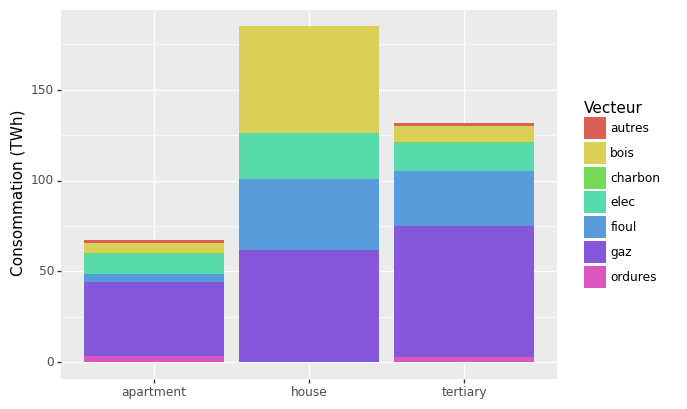

In [305]:
# region plot data shaping
init_stock=sim_param_copy4plot["init_sim_stock"].copy()


init_stock=init_stock.drop(['IPONDL'],axis=1)
init_stock=pd.melt(init_stock,id_vars=['proportion_energy_need','energy_need_per_surface','surface'],value_name='conso_unitaire',ignore_index=False)
init_stock[['v1','v2','Vecteur']]=init_stock['variable'].str.split('_',expand=True)
init_stock=init_stock.drop(['v1','v2','variable'],axis=1)
init_stock=init_stock.reset_index()
init_stock=init_stock[init_stock['conso_unitaire'] > 0]

init_stock=init_stock.set_index(["Energy_source", "building_type", "Vecteur"])

data_frames=[init_stock,sim_param_copy4plot['seasonal_efficiency'],sim_param_copy4plot['peak_efficiency'],sim_param_copy4plot['direct_emissions'],sim_param_copy4plot['indirect_emissions']]

init_stock = reduce(lambda  left,right: pd.merge(left,right,
                                            left_index=True,right_index=True), data_frames)

init_stock=init_stock.reset_index().set_index(["Energy_source", "building_type", "Vecteur"])
init_stock['Besoin']=init_stock['proportion_energy_need']*init_stock['energy_need_per_surface']*init_stock['surface']*init_stock['conso_unitaire']/10**9
init_stock['Consumption']=init_stock['Besoin']/init_stock['seasonal_efficiency']
init_stock['Emissions']=init_stock['Consumption']*(init_stock['indirect_emissions']+init_stock['direct_emissions'])/10**3

initial_need=init_stock['Besoin'].sum()
initial_emissions=init_stock['Emissions'].sum()
initial_consumption=init_stock['Consumption'].sum()
initial_need_surface=initial_need*10**9/(init_stock['surface']*init_stock['conso_unitaire']).sum()
# endregion
print("Conso totale :"+str(round(initial_consumption,0))+ " TWh et conso d'élec :"+
      str(round(init_stock.loc[(slice(None),slice(None),"elec"),"Consumption"].sum(),0))+" TWh")
print("Besoin énergétique bâtiments :"+str(round(initial_need_surface,0))+ " kWh/m²")

## Drawing the energy consumption by energy vector
forplot=init_stock.groupby(['building_type','Vecteur']).agg('sum').reset_index()
fig=(
    ggplot(forplot)+
    geom_col(aes(x='building_type',y="Consumption",fill='Vecteur'))+
    ylab("Consommation (TWh)")+
    xlab('')
)
p = fig.draw()

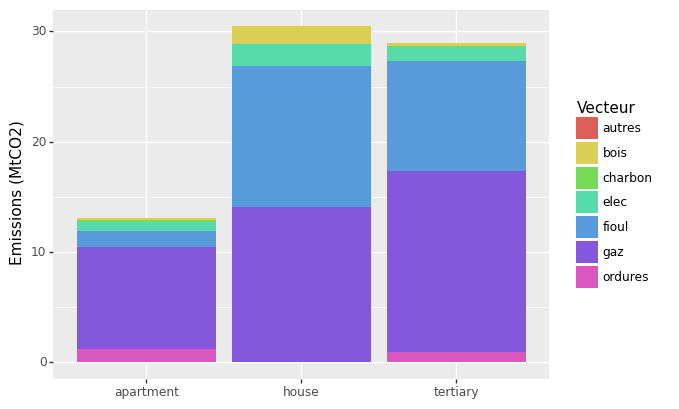

In [306]:
## Drawing the CO2 emissions by energy vector
fig=(
    ggplot(forplot)+
    geom_col(aes(x='building_type',y="Emissions",fill='Vecteur'))+
    ylab("Emissions (MtCO2)")+
    xlab('')
)
p = fig.draw()

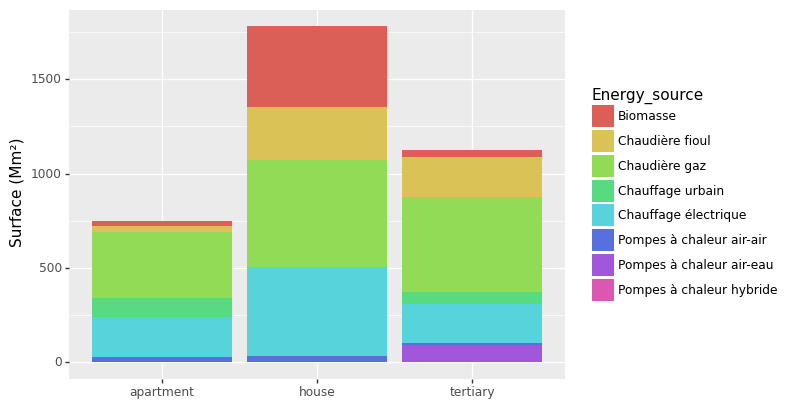

In [307]:
## Drawing the energy surface by energy source
forplot2=init_stock.groupby(['Energy_source','building_type'])["surface"].agg('mean').reset_index().filter(['Energy_source','building_type','surface','Consumption','Emissions'])
forplot2["surface"]=forplot2["surface"]/10**6

fig=(
    ggplot(forplot2)+
    geom_col(aes(x='building_type',y="surface",fill='Energy_source'))+
    ylab("Surface (Mm²)")+
    xlab('')
)
p = fig.draw()

We can see that GHG emissions mainly come from gas an fuel, as electricity and wood have a low emission factor. Replacing the heating systems burning such fuels is thus the priority. Also, heating network are mainly used in apartments and teritary buildings.

For the electricity peak, knowing that the actual residential electricity demand (about 35 TWh) represent a thermosensitivity of 1.5kW/°C (based on Enedis observations), we can estimate the global thermosensitivity due to electric heating in the residential and tertiary sectors.

In [308]:
init_stock_init=init_stock.copy().reset_index()
init_stock_init=init_stock_init[init_stock_init["Vecteur"]=='elec']
themosensitivity=np.sum(init_stock_init['Consumption']*1.5/35/init_stock_init['peak_efficiency'])
print(themosensitivity)

2.1794835488008437


The peak electricity demand can thus be estimated by calculating the peak power at a very cold temperature (typically -5°C). Compare this value with French installed power capacity.

In [309]:
T_base=-5
initial_peak_power=themosensitivity*(15-T_base)
initial_peak_power

43.589670976016876

## 3. Decarbonization of building stock heating <a class="anchor" id="decarbonization"></a>
We define some functions which will permit to estimate all the indicators, year by year. The three indicators we monitor are energy consumption, GHG emissions and electricity peak The heating need and final consumption are then calculated for each energy_source.

In [319]:
def f_Compute_conso(x,sim_param,Vecteur):
    conso_unitaire = x["conso_unitaire_"+Vecteur]
    Energy_source = x.name[sim_param['base_index'].names.index('Energy_source')]
    seasonal_efficiency=sim_param["seasonal_efficiency"][(Energy_source,Vecteur)]
    conso_unitaire=conso_unitaire/seasonal_efficiency
    return x["energy_need_per_"+sim_param["volume_variable_name"]] * x[sim_param["volume_variable_name"]]*x["proportion_energy_need"]*conso_unitaire
def f_Compute_conso_totale(x,sim_param):
    res=0.
    for Vecteur in sim_param["Vecteurs"]:
        res+=x["conso_"+Vecteur]
    return res

def f_Compute_besoin(x,sim_param): return x["energy_need_per_surface"] * x["surface"]*x["proportion_energy_need"]
sim_param["f_Compute_besoin"]={"Besoin" : f_Compute_besoin}

def f_compute_emissions(x, sim_param, year, Vecteur):
    return sim_param["direct_emissions"].loc[Vecteur, year] * x["conso_" + Vecteur] + \
           sim_param["indirect_emissions"].loc[Vecteur, year] * x["conso_" + Vecteur]

def f_Compute_emissions_totale(x, sim_param):
    res = 0.
    for Vecteur in sim_param["Vecteurs"]:
        res += x["emissions_" + Vecteur]
    return res

def f_Compute_electrical_peak(x, sim_param):
    Energy_source = x.name[sim_param['base_index'].names.index('Energy_source')]
    return x["conso_elec"] * 1.5 / 35  / sim_param["peak_efficiency"][(Energy_source,"elec")]*sim_param["share_peak"][(Energy_source,"elec")]

For drawing the scenarios towards 2050, some pre-processing is needed to interpolahe the evolution of some parameters indexed along year.

In [320]:
def update_inputs(data_set_from_excel,sim_param,Index_names,dim_names):
    sim_param = interpolate_sim_param(sim_param)
    sim_param["retrofit_change_surface"]=sim_param["retrofit_change_total_proportion_surface"].diff().fillna(0)

    Para_2_fill = {param: sim_param["base_index_year"] for param in
                       ["retrofit_improvement", "retrofit_change_surface", "retrofit_Transition"]}
    sim_param = complete_parameters(sim_param, Para_2_fill=Para_2_fill)
    sim_param["retrofit_change_surface"]=sim_param["retrofit_change_surface"]*sim_param["init_sim_stock"]["surface"]

    sim_param = complete_missing_indexes(data_set_from_excel, sim_param, Index_names, dim_names)
    
    for Vecteur in sim_param["Vecteurs"]:
        sim_param["f_Compute_conso_"+Vecteur]={"conso_"+Vecteur : partial(f_Compute_conso,Vecteur =Vecteur)}
    sim_param["f_Compute_conso_totale"]={"Conso" : lambda x,sim_param: f_Compute_conso_totale(x,sim_param)}

    sim_param["f_Compute_besoin"]={"Besoin" : f_Compute_besoin}

    for Vecteur in sim_param["Vecteurs"]:
        sim_param["f_Compute_emissions_"+Vecteur]={"emissions_"+Vecteur : partial(f_compute_emissions,Vecteur =Vecteur)}
    sim_param["f_Compute_emissions_totale"]={"emissions" : lambda x,sim_param: f_Compute_emissions_totale(x,sim_param)}

    sim_param["f_Compute_electrical_peak_totale"] = {
        "electrical_peak": lambda x, sim_param: f_Compute_electrical_peak(x, sim_param)}
 
    return sim_param

sim_param=update_inputs(data_set_from_excel,sim_param,Index_names,dim_names)

The retrofit scenario is defined by two elements:
1. The retrofit transition matrix: defines the switch from one heating system to another
2. The thermal retrofit savings: defines in what extent the energy need is reduced when buildings are retrofitted

In [298]:
#Transition matrix for apartments
b_type="apartment"
transition_matrix=sim_param['retrofit_Transition'].copy().rename_axis(columns=None).reset_index()
transition_matrix.loc[(transition_matrix["year"]==2020) & (transition_matrix["building_type"]==b_type)].drop([\
                                        "old_new","building_type","year"],axis=1).set_index('Energy_source').transpose()

Energy_source,Biomasse,Chaudière fioul,Chaudière gaz,Chauffage urbain,Chauffage électrique,Pompes à chaleur air-air,Pompes à chaleur air-eau,Pompes à chaleur hybride
Biomasse,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Chaudière fioul,0.037922,0.0,0.000000,0.150208,0.000000,0.090828,0.721041,0.0
Chaudière gaz,0.036064,0.0,0.176909,0.151599,0.000000,0.064450,0.569147,0.0
Chauffage urbain,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
Chauffage électrique,0.031719,0.0,0.000000,0.158977,0.295539,0.513765,0.000000,0.0
Pompes à chaleur air-air,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
Pompes à chaleur air-eau,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
Pompes à chaleur hybride,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [299]:
retrofit_improvement=sim_param['retrofit_improvement'].copy().reset_index()
retrofit_improvement.loc[(retrofit_improvement["Energy_source"]=="Biomasse") & (retrofit_improvement["building_type"]=="apartment")]\
                                        .drop(['Energy_source','building_type'],axis=1).set_index("year")

,retrofit_improvement
year,
2020,0.050000
2021,0.051667
2022,0.053333
2023,0.055000
2024,0.056667
2025,0.058333
2026,0.060000
2027,0.061667
2028,0.063333


Let's now look at the first scenario results. We first initiate the simulation.


### 3.1 An example path towards emission reduction <a class="anchor" id="firstpath"></a>
Considering all the inputs described above, we can launch the simulation of the scenario. The simulation function calculates the surface to be retrofitted each year, the energy need of the surface after retrofit and the energy_source which will provide the energy_need and the switches from one energy source to another.

In [321]:
sim_stock = launch_simulation(sim_param)

Computing: [########################################] 29/29



We collect the output data into a dataframe we can exploit to do some plot and analysis.

Here comes the evolution of energy needs of buildings, splitted by building type.

In [227]:
sim_stock_df = pd.concat(sim_stock, axis=0).reset_index().\
    rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

In [228]:
Var = "Besoin"
y_df = sim_stock_df.groupby(["year", "building_type"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='building_type').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 9
fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Besoin d'énergie de chauffage par vecteur énergétique (en TWh)", xaxis_title="Année",
                        yaxis_title="Besoin [TWh]")
fig.show()

But it is also possible to plot the evolution of energy consumption or GHG emissions due to heating.

In [229]:
Var = "Conso"
y_df = sim_stock_df.groupby(["year", "Energy_source"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='Energy_source').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 9
fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Conso d'énergie par mode de chauffage (en TWh)", xaxis_title="Année",
                        yaxis_title="Consommation [TWh]")
fig.show()

In [230]:
Var = "emissions"
y_df = sim_stock_df.groupby(["year", "Energy_source"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='Energy_source').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 12

fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Emissions de GES par mode de chauffage (en MtCO2e)", xaxis_title="Année",
                        yaxis_title="Emissions [MtCO2e]")
fig.show()

One key indicator of the decarbonization pathways is the reduction of GHG emissions. In the case of this first scenario, we can vizualize the following key indicators:

In [231]:
emission_reduction=sim_stock_df.copy().reset_index()
emission_reduction=(initial_emissions-emission_reduction[emission_reduction["year"]==2049]["emissions"].sum()/10**12)/initial_emissions

energy_cons_reduction=sim_stock_df.copy().reset_index()
energy_cons_reduction=(initial_consumption-energy_cons_reduction[energy_cons_reduction["year"]==2049]["Conso"].sum()/10**9)/initial_consumption

energy_need_reduction=sim_stock_df.copy().reset_index()
energy_need_reduction=(initial_need-energy_need_reduction[energy_need_reduction["year"]==2049]["Besoin"].sum()/10**9)/initial_need

print("Réduction des émissions de GES: " + str(np.round(emission_reduction*100,2)) + "%")
print("Réduction de la consommation: " + str(np.round(energy_cons_reduction*100,2)) + "%")
print("Réduction du besoin: " + str(np.round(energy_need_reduction*100,2)) + "%")


Réduction des émissions de GES: 63.01%
Réduction de la consommation: 42.36%
Réduction du besoin: 7.3%


### 3.2 Achieving SNBC objectives through electrification <a class="anchor" id="electrification"></a>
The french national decarbonisation strategy targets to reduce by 95% emissions from heating by 2050 (respect to 2015).
As you can observe in the previous graphs, the SNBC objectives are not met by the proposed scenario.
One way of reducing heating emissions is the electrification of heating systems. By modifying the shift proportions in the retrofit matrix, propose a scenario with a strong electricity penetration (electric heating, heat pumps) which gets clother the SNBC objectives (CAUTION: All rows should sum up to 1):

In [322]:
sim_param = extract_sim_param(data_set_from_excel, Index_names=Index_names, dim_names=dim_names,
                              Energy_system_name=Energy_system_name)
#Creating the initial building description
sim_param["init_sim_stock"] = create_initial_parc(sim_param).sort_index()
sim_param["volume_variable_name"] = "surface"
sim_param["init_sim_stock"]["surface"] = sim_param["init_sim_stock"]["surface"] * sim_param["init_sim_stock"]["IPONDL"]

# We adjust energy need for electricity considering the primary energy factor
sim_param["init_sim_stock"]["conso_unitaire_elec"]=sim_param["init_sim_stock"]["conso_unitaire_elec"]/2.3

## for those able to make qgrid work, you should be able to modify the table sim_param['retrofit_Transition'] within the interface below
#https://github.com/quantopian/qgrid
col_def = { col :  { 'editable': True } for col in sim_param['retrofit_Transition'].columns}
qgrid_widget = qgrid.show_grid(sim_param['retrofit_Transition'], show_toolbar=True, column_definitions=col_def)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [323]:
# retrofit_transition_electrified=qgrid_widget.get_changed_df()
sim_param['retrofit_Transition']=retrofit_transition_electrified.copy()

sim_param=update_inputs(data_set_from_excel,sim_param,Index_names,dim_names)

# We lanch the simulation
sim_stock_new = launch_simulation(sim_param)

sim_stock_new_df = pd.concat(sim_stock_new, axis=0).reset_index().\
    rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

Computing: [########################################] 29/29



In [285]:
Var = "Conso"
y_df = sim_stock_new_df.groupby(["year", "Energy_source"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='Energy_source').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 9
fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Conso d'énergie par mode de chauffage (en TWh)", xaxis_title="Année",
                        yaxis_title="Consommation [TWh]")
fig.show()

In [286]:
emission_reduction=sim_stock_new_df.copy().reset_index()
emission_reduction=(initial_emissions-emission_reduction[emission_reduction["year"]==2049]["emissions"].sum()/10**12)/initial_emissions

energy_cons_reduction=sim_stock_new_df.copy().reset_index()
energy_cons_reduction=(initial_consumption-energy_cons_reduction[energy_cons_reduction["year"]==2049]["Conso"].sum()/10**9)/initial_consumption

energy_need=sim_stock_new_df.copy().reset_index()
energy_need_reduction=(initial_need-energy_need[energy_need["year"]==2049]["Besoin"].sum()/10**9)/initial_need

surface_energy_need=(energy_need[energy_need["year"]==2049]["Besoin"].sum())/(energy_need[energy_need["year"]==2049]["surface"].sum())

print("Réduction des émissions de GES: " + str(np.round(emission_reduction*100,2)) + "%")
print("Réduction de la consommation: " + str(np.round(energy_cons_reduction*100,2)) + "%")
print("Réduction du besoin: " + str(np.round(energy_need_reduction*100,2)) + "%")
print("Besoin final du parc: " + str(np.round(surface_energy_need,2)) + "kWh/m²")

Réduction des émissions de GES: 82.41%
Réduction de la consommation: 57.59%
Réduction du besoin: 4.34%
Besoin final du parc: 94.05kWh/m²


This new stock configuration, highly electrified, also impacts the electrical grid. Vizualize the new electrical peak and compare it with French installed capacity.

In [287]:
final_stock=sim_stock_new_df.copy().reset_index()

themosensitivity_init=np.sum(final_stock[final_stock["year"]==2021]['electrical_peak']/10**9)
themosensitivity=np.sum(final_stock[final_stock["year"]==2049]['electrical_peak']/10**9)

print("Termosensibilité: " + str(np.round(themosensitivity,2)) + "GW/°C")
peak_power=themosensitivity*(15-T_base)
print("Nouveau pic électrique: " + str(np.round(peak_power,1)) +"GW")
print("Ajout de puissance lors du pic électrique: " + str(np.round(peak_power-initial_peak_power,1)) +"GW")
print("Augmentation du pic électrique: +" + str(np.round((peak_power-initial_peak_power)/initial_peak_power*100,1)) +"%")

Termosensibilité: 3.2GW/°C
Nouveau pic électrique: 64.0GW
Ajout de puissance lors du pic électrique: 20.4GW
Augmentation du pic électrique: +46.8%


### 3.3 Technical constraints and alternative paths <a class="anchor" id="alternatives"></a>
The previous analysis highlighted the fact that it is not possible to simply electrify all heating uses, otherwise a high increase of the electericity peak demand is not compatible with the power production system.


Two main solutions can be discussed to reduce the electric heating peak demand while evoluting towards SNBC targets: hybrid heat pumps (which are basically a heat pump with a gas boiler providing heat during the coldest days of the year) and the use of biogas to keep a high share of gas boilers in the heating systems mix.
You can design two scenarios for both options, and discuss the results

In [324]:
## First scenario: deployment of Hybrid heat_pumps instead of A/W
sim_param = extract_sim_param(data_set_from_excel, Index_names=Index_names, dim_names=dim_names,
                              Energy_system_name=Energy_system_name)
#Creating the initial building description
sim_param["init_sim_stock"] = create_initial_parc(sim_param).sort_index()
sim_param["volume_variable_name"] = "surface"
sim_param["init_sim_stock"]["surface"] = sim_param["init_sim_stock"]["surface"] * sim_param["init_sim_stock"]["IPONDL"]

# We adjust energy need for electricity considering the primary energy factor
sim_param["init_sim_stock"]["conso_unitaire_elec"]=sim_param["init_sim_stock"]["conso_unitaire_elec"]/2.3

## for those able to make qgrid work, you should be able to modify the table sim_param['retrofit_Transition'] within the interface below
#https://github.com/quantopian/qgrid
col_def = { col :  { 'editable': True } for col in sim_param['retrofit_Transition'].columns}
qgrid_widget = qgrid.show_grid(sim_param['retrofit_Transition'], show_toolbar=True, column_definitions=col_def)
qgrid_widget


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [325]:
# retrofit_transition_Hybrid_HP=qgrid_widget.get_changed_df()
sim_param['retrofit_Transition']=retrofit_transition_Hybrid_HP.copy()
sim_param=update_inputs(data_set_from_excel,sim_param,Index_names,dim_names)

# We lanch the simulation
sim_stock_new2 = launch_simulation(sim_param)

sim_stock_new2_df = pd.concat(sim_stock_new2, axis=0).reset_index().\
    rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

Computing: [########################################] 29/29



In [330]:
# sim_stock_new2_df = pd.concat(sim_stock_new2_df, axis=0).reset_index().\
#     rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

final_stock=sim_stock_new2_df.copy().reset_index()
emission_reduction=(initial_emissions-final_stock[final_stock["year"]==2049]["emissions"].sum()/10**12)/initial_emissions

energy_cons_reduction=sim_stock_new_df.copy().reset_index()
energy_cons_reduction=(initial_consumption-final_stock[final_stock["year"]==2049]["Conso"].sum()/10**9)/initial_consumption

energy_need=sim_stock_new_df.copy().reset_index()
energy_need_reduction=(initial_need-final_stock[final_stock["year"]==2049]["Besoin"].sum()/10**9)/initial_need

surface_energy_need=(final_stock[final_stock["year"]==2049]["Besoin"].sum())/(final_stock[final_stock["year"]==2049]["surface"].sum())

print("Réduction des émissions de GES: " + str(np.round(emission_reduction*100,2)) + "%")
print("Réduction de la consommation: " + str(np.round(energy_cons_reduction*100,2)) + "%")
print("Réduction du besoin: " + str(np.round(energy_need_reduction*100,2)) + "%")
print("Besoin final du parc: " + str(np.round(surface_energy_need,2)) + "kWh/m²")

themosensitivity_init=np.sum(final_stock[final_stock["year"]==2021]['electrical_peak']/10**9)
themosensitivity=np.sum(final_stock[final_stock["year"]==2049]['electrical_peak']/10**9)

print("Termosensibilité: " + str(np.round(themosensitivity,2)) + "GW/°C")
peak_power=themosensitivity*(15-T_base)
print("Nouveau pic électrique: " + str(np.round(peak_power,1)) +"GW")
print("Ajout de puissance lors du pic électrique: " + str(np.round(peak_power-initial_peak_power,1)) +"GW")
print("Augmentation du pic électrique: " + str(np.round((peak_power-initial_peak_power)/initial_peak_power*100,1)) +"%")

Réduction des émissions de GES: 86.35%
Réduction de la consommation: 67.01%
Réduction du besoin: 18.59%
Besoin final du parc: 80.03kWh/m²
Termosensibilité: 1.5GW/°C
Nouveau pic électrique: 30.1GW
Ajout de puissance lors du pic électrique: -13.5GW
Augmentation du pic électrique: +-31.1%


In [389]:
# Second scenario: change the share of biogas in the mix in 2050
sim_param = extract_sim_param(data_set_from_excel, Index_names=Index_names, dim_names=dim_names,
                              Energy_system_name=Energy_system_name)
#Creating the initial building description
sim_param["init_sim_stock"] = create_initial_parc(sim_param).sort_index()
sim_param["volume_variable_name"] = "surface"
sim_param["init_sim_stock"]["surface"] = sim_param["init_sim_stock"]["surface"] * sim_param["init_sim_stock"]["IPONDL"]

# We adjust energy need for electricity considering the primary energy factor
sim_param["init_sim_stock"]["conso_unitaire_elec"]=sim_param["init_sim_stock"]["conso_unitaire_elec"]/2.3

## for those able to make qgrid work, you should be able to modify the table sim_param['retrofit_Transition'] within the interface below
#https://github.com/quantopian/qgrid
# col_def = { col :  { 'editable': True } for col in sim_param['biogas_share'].columns}
qgrid_widget = qgrid.show_grid(sim_param['biogas_share'], show_toolbar=True, column_definitions=col_def)
qgrid_widget


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [403]:
# # biogas_share=qgrid_widget.get_changed_df()
# # sim_param['biogas_share']=biogas_share.copy()
# # sim_param=update_inputs(data_set_from_excel,sim_param,Index_names,dim_names)


# def f_Compute_new_emission_gas(x,sim_param,year): return x["direct_emissions"] * sim_param["surface"]*x["proportion_energy_need"]
# sim_param["f_Compute_besoin"]={"Besoin" : f_Compute_besoin}

# # direct_emissions=sim_param['direct_emissions'].copy()
# # biogas_share=sim_param['biogas_share'].copy()


# # firsts = direct_emissions.index.get_level_values('year')
# # biogas_share = biogas_share.loc[firsts].values

# # biogas_share =1-biogas_share*(direct_emissions.index.get_level_values('Vecteur')=="gaz")
# biogas_share
# # biogas_share = biogas_share*(modified_emissions["Vecteur"]=="gaz")
# sim_param['direct_emissions'].multiply(biogas_share,axis=0)
# # sim_param['indirect_emissions']=sim_param['indirect_emissions']*biogas_share
# # biogas_share
# # direct_emissions=sim_param['direct_emissions'].copy().reset_index()
# # modified_emissions=pd.merge(direct_emissions,biogas_share,on=['year'])
# # sim_param['direct_emissions']
# # modified_emissions[modified_emissions["Vecteur"]=="gaz"].loc["direct_emissions"]=modified_emissions[modified_emissions["Vecteur"]=="gaz"].loc["direct_emissions"]*(1-modified_emissions[modified_emissions["Vecteur"]=="gaz"].loc["biogas_share"])
                                                                                

# # modified_emissions["direct_emissions"]
# # # We lanch the simulation
# # sim_stock_new2 = launch_simulation(sim_param)

# # sim_stock_new2_df = pd.concat(sim_stock_new2, axis=0).reset_index().\
# #     rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

ValueError: Data must be 1-dimensional

### 3.4 Achieving SNBC target by combining all the options <a class="anchor" id="final"></a>
At the end, we have the impression that each scenario cannot represent a solution on its own. A combination of all technical solution might permit to meet SNBC targets.
You must now design a scenario which uses the following levers:
1. Thermal retrofit of buildings
2. Electrification of heating (using hybrid heat-pumps to reduce the peak)
3. Injection of biomethane in the mix

You can, if you want, try to adjust other parameters such as the heat networks carbon content, the share of wood heating in the mix, ...

## 4. Input data structure <a class="anchor" id="inputdata"></a>

All the data input are stored in the excel file data/Hypotheses_tertiaire_1D.xlsx. There are different excel sheets in the document, each of which represents input data indexed on different variables.

### 4.1. Global 0-Dim inputs
In this first sheet, global 0D values are defined:
- Initial state of the building stock: the heat need of existing buildings and the share of need due to space heating
- Parameters of newly built buildings: the heat need of new buildings and the area of newly build buildings per year
- Horizon parameters such as the start and end date of the simulation and the final retrofited share

### 4.2. Inputs indexed by Energy-source
Some values are indexed by the energy source, such as:
- The initial surface heated by each energy source
- The energy repartition by fuel, including efficiency and energy share along the year (for hybrid systems)
- The surface to be retrofitted by energy source. These surfaces are estimated to guarantee that 100% of buildings are retrofitted by 2050.


### 4.3. Input indexed by year

### 4.4. Inputs indexed by Energy-source x

### 4.5. Retrofit transition matrix